## Lab 2 - Exploring Image Data
### By. Liam Lowsley-Williams, Eli Laird, Fernando Vazquez

## Business Understanding

For this lab we chose to use a dataset that consists of satellite images of ships traveling the seas. These images are aerial views of two categories, one being images which contain ships and the other being images that do not contain ships. The dataset contains 1000 images that are classified as having ships in them and 3000 images that do not. The images were extracted from planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. We hope to be able to classify whether images in the test dataset have or do not have ships in them.

The dataset was taken from www.kaggle.com and the reason behind its curation, according to the creator, is to “help address the difficult task of detecting the location of large ships in satellite images.” He continues, “Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.” This is primarily the reason we are interested in using this dataset. Being able to identify ships via satellite images could be immensely useful in automating a wide variety of issues. For example, it could be used to maintain maritime sovereignty for governments around the world, allowing countries to identify whether a ship has entered a nation’s water along with other useful information like size and type. It could also be used to identify illegal activities such as poaching, drug trafficking, and stolen vessels. Being able to identify this information would help keep the waters safe for all humans and maritime animals alike. Lastly, it could also be very useful for analytic data as well. Being able to obtain statistics regarding motorized vessels that are traveling or sitting in bodies of water around the world could potentially provide interesting insight when further analyzed.

In our use case, our prediction task would be to identify whether or not there is a ship in a given satellite image. The third parties that could be potentially interested in this algorithm are shipping companies, harbor managers, research groups, federal, state and local law enforcement agencies, and maritime tracking companies. It would also be very useful to governments because they are typically the overseers of the world and have access to the satellites and the technology to collect more data. However, in order for this algorithm to be useful to third parties, we would need to get more data from around the globe. This lab is more tailored as a feasibility study due to the limited dataset it utilizes and lack of variance in worldwide data.

Dataset - https://www.kaggle.com/rhammell/ships-in-satellite-imagery 

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt
import cv2
import os

In [2]:
file_path= './shipsnet/shipsnet/'

images_dir = os.listdir(file_path)

# read in images
images = []
labels_ext = []

error_count = 0
for img in images_dir:
    image = cv2.imread(file_path + img, cv2.IMREAD_GRAYSCALE)
    try:
        images.append(image.flatten())
        label = 'ship' if img[0] == '1' else 'no ship'
        labels_ext.append((label,img))
    except:
        error_count += 1

# create our variables for images and labels
images = np.array(images)
labels_ext = np.array(labels_ext)
labels = [i[0] for i in labels_ext]

# specify height and width
h, w = (80,80)

print("{} Images failed to resize".format(error_count))
print("Image size:", images[0].shape)
print("Image Count:", len(images))

FileNotFoundError: [Errno 2] No such file or directory: './shipsnet/shipsnet/'

In [3]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=18)
    for n,i in enumerate(rand_sample):
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i].reshape((h,w)))
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())

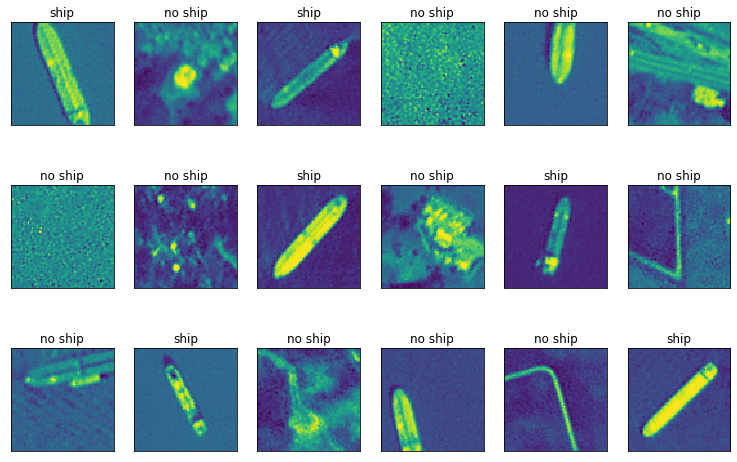

In [4]:
# plot images
plot_gallery(images, labels, h, w)

## Data Reduction

In [5]:
# re-assign variable names to make sense
X = images
y = labels

### Linear Dimensionality Reduction - PCA

In [6]:
from sklearn.decomposition import PCA
import pickle

n_components = 300

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
eigenships_pca = pca.components_.reshape((n_components, h, w))

# pickle dump
pickle.dump(eigenships_pca, open('eigenships_pca.p', 'wb'))

CPU times: user 12.9 s, sys: 351 ms, total: 13.2 s
Wall time: 2.23 s


In [7]:
# pickle load pca
eigenships_pca = pickle.load(open('eigenships_pca.p','rb'))

In [8]:
# function to plot variance
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode()
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [9]:
# plot variance
plot_explained_variance(pca)

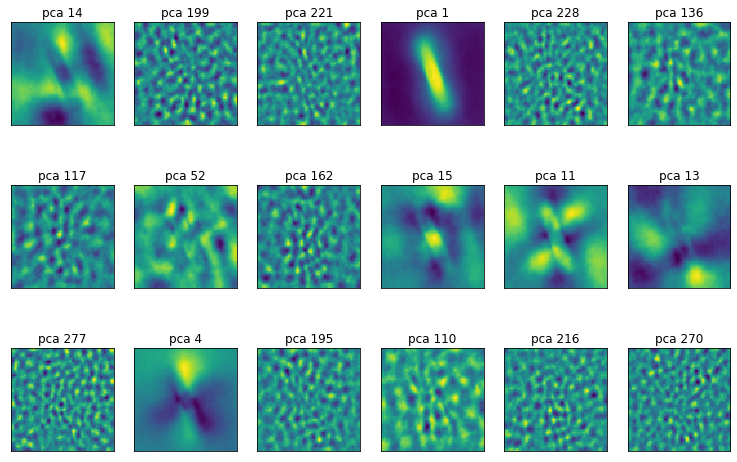

In [10]:

eigenships_pca_titles = ["pca %d" % i for i in range(eigenships_pca.shape[0])]
plot_gallery(eigenships_pca, eigenships_pca_titles, h, w)

In [11]:
# function to reconstruct image
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
# index to reconstruct
idx_to_reconstruct = 1    
X_idx = X[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

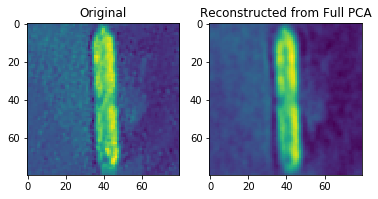

In [12]:
# plot original image against image reconstructed with full PCA
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)))
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)))
plt.title('Reconstructed from Full PCA')
plt.grid(False)

## Non-Linear Dimensionality Reduction - KPCA

In [22]:
from sklearn.decomposition import KernelPCA
n_components = 300

# kernel pca with linear kernel
kpca_linear = KernelPCA(
    n_components=n_components, 
    kernel='linear', 
    fit_inverse_transform=True,
    remove_zero_eig=True,
    n_jobs=-1)  
%time kpca_linear.fit(X.copy())

CPU times: user 51.1 s, sys: 4.76 s, total: 55.9 s
Wall time: 7.97 s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=True, gamma=None, kernel='linear',
          kernel_params=None, max_iter=None, n_components=300, n_jobs=-1,
          random_state=None, remove_zero_eig=True, tol=0)

In [ ]:
#pickle dump kpca linear
pickle.dump(kpca_linear, open( 'eigenships_kpca_linear.p', 'wb' ))

In [ ]:
# pickle load kpca linear
kpca_linear = pickle.load(open('eigenships_kpca_linear.p','rb'))

In [20]:
# kernel pca with polynomial kernel
kpca_poly = KernelPCA(
    n_components=n_components, 
    kernel='poly', 
    fit_inverse_transform=True,
    remove_zero_eig=True,
    n_jobs=-1)  
%time kpca_poly.fit(X.copy())

CPU times: user 53 s, sys: 4.43 s, total: 57.5 s
Wall time: 8.08 s


/Users/eli/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/decomposition/kernel_pca.py:257: LinAlgWarning:

Ill-conditioned matrix (rcond=7.19491e-17): result may not be accurate.



KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=True, gamma=None, kernel='poly',
          kernel_params=None, max_iter=None, n_components=300, n_jobs=-1,
          random_state=None, remove_zero_eig=True, tol=0)

In [16]:
# pickle dump kpca poly
pickle.dump(kpca_poly, open( 'eigenships_kpca_poly.p', 'wb' ))

In [ ]:
# pickle load kcpa poly
kpca_poly = pickle.load(open('eigenships_kpca_poly.p','rb'))

In [23]:
import warnings
from ipywidgets import widgets

# function for widget slider for images
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca_linear = kpca_linear.inverse_transform(kpca_linear.transform(X[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca_poly = kpca_poly.inverse_transform(kpca_poly.transform(X[idx_to_reconstruct].reshape(1, -1)))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)))
    plt.title('Original')
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)))
    plt.title('Full PCA')
    plt.grid()

    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca_linear.reshape((h, w)))
    plt.title('Kernel PCA - Linear')
    plt.grid()
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca_poly.reshape((h, w)))
    plt.title('Kernel PCA - Poly')
    plt.grid()
    
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,X.shape[0]-1,1),__manual=True)

interactive(children=(IntSlider(value=1999, description='idx_to_reconstruct', max=3999), Output()), _dom_class…

<function __main__.plt_reconstruct(idx_to_reconstruct)>

## Feature Extraction - DAISY

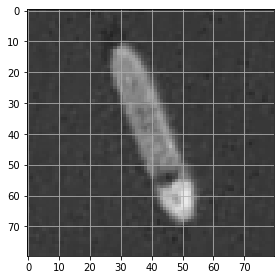

In [24]:
from skimage.io import imshow
# choose random image to perform DAISY on
idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid()

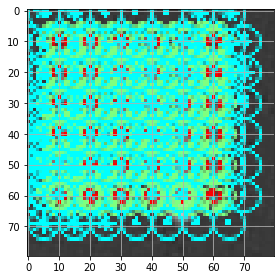

In [25]:
from skimage.feature import daisy
# visualize what daisy would look like on image
features, img_desc = daisy(img, 
                           step=40, 
                           radius=10, 
                           rings=2, 
                           histograms=6, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid()

In [26]:
# function that will take an image and perform daisy feature extraction
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

CPU times: user 10.5 ms, sys: 2.19 ms, total: 12.7 ms
Wall time: 11.4 ms


(3744,)

In [27]:
# apply function above to all images, row by row
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 27.6 s, sys: 362 ms, total: 28 s
Wall time: 28 s
(4000, 3744)


In [28]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 2.52 s, sys: 54.8 ms, total: 2.58 s
Wall time: 506 ms


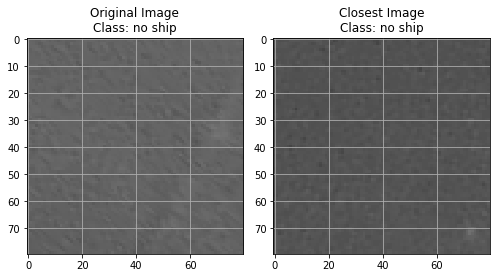

In [29]:
import copy
# specify index to look at
idx1 = 200

# given index find an image with the closest pairwise 
#   differnce and display it
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty
idx2 = np.argmin(distances)

# plot
plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image\nClass: {}".format(y[idx1]))
plt.grid()
plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image\nClass: {}".format(y[idx2]))
plt.grid()

In [32]:
from ipywidgets import fixed

# function that will find the closest and next closest image
#   to a given image with a specified index from widget slider
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:])
    distances[idx1] = np.infty
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)))
    plt.title("Origina Image\nClass: {}".format(y[idx1]))
    plt.grid()
    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image\nClass: {}".format(y[idx2]))
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)))
    plt.title("Next Closest Image\nClass: {}".format(y[idx3]))
    plt.grid()
    
widgets.interact(closest_image,idx1=(0,X.shape[0]-1,1),dmat=fixed(dist_matrix),__manual=True)


interactive(children=(IntSlider(value=1999, description='idx1', max=3999), Output()), _dom_classes=('widget-in…

<function __main__.closest_image(dmat, idx1)>

## Exceptional Work